In [1]:
import pandas as pd
import re
import string
from gensim import matutils, models
import scipy.sparse
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import nltk

In [2]:
df = pd.read_csv("data/pd_rev_de.csv")

In [3]:
df.head()

,Unnamed: 0,date,author,text,title,stars,location,url,language
0,0,2022-05-19,Isabelle,Vielen Dank für die nette Beratung. Mir wurden...,Nette uns Komponenten Beratung,5,DE,https://www.trustpilot.com/review/plusdental.d...,de
1,1,2022-05-19,Diana Rosenkranz,Super strukturiertet und transparenter Ablauf....,Super strukturiertet und transparenter Ablauf,5,DE,https://www.trustpilot.com/review/plusdental.d...,de
2,2,2022-05-19,Mohammad Zahid Kamal,"Das einzig Gute ist, dass der Arzt mit mir auf...",Das einzig Gute ist,3,DE,https://www.trustpilot.com/review/plusdental.d...,de
3,3,2022-05-19,Angelina M,Sehr freundlich und sehr zuversichtlich,Freundlich,5,DE,https://www.trustpilot.com/review/plusdental.d...,de
4,4,2022-05-19,Rachid D,Alles gut einfach super,Alles gut einfach super,4,DE,https://www.trustpilot.com/review/plusdental.d...,de


In [194]:
documents = df.copy()
documents = documents[['text']]

# Convert all words to lowercase
documents['text'] = documents['text'].str.lower()

# Remove non-alphabet
documents['text'].str.replace('[^a-zA-Z]', '', regex=True)
documents['text'] = documents['text'].str.replace('\d+', '', regex=True)
documents['text'] = documents['text'].str.replace('\n', '', regex=True)
documents.head(10)

,text
0,vielen dank für die nette beratung. mir wurden...
1,super strukturiertet und transparenter ablauf....
2,"das einzig gute ist, dass der arzt mit mir auf..."
3,sehr freundlich und sehr zuversichtlich
4,alles gut einfach super
5,ich bin mit dem ersten besuch bei plus dental ...
6,schnell und professionell.
7,ich bin durchweg positiv überrascht. am anfang...
8,ich war sehr zufrieden mit der behandlung
9,kein feedback. falsches kiefer berechnet und w...


In [195]:
stop_words = stopwords.words('german')
stop_words.extend(["plusdental", "schon", "immer",
                   "ganz", "doch", "jedoch",
                   "mal", "tun", "war",
                   "herr", "frau", "davon",
                   "genau", "wirklich",
                   "gar", "echt", "eignen",
                   "deshalb","Schiene", "Schienen"
                   ])

In [196]:
stop_words

['aber',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'als',
 'also',
 'am',
 'an',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer',
 'anderes',
 'anderm',
 'andern',
 'anderr',
 'anders',
 'auch',
 'auf',
 'aus',
 'bei',
 'bin',
 'bis',
 'bist',
 'da',
 'damit',
 'dann',
 'der',
 'den',
 'des',
 'dem',
 'die',
 'das',
 'dass',
 'daß',
 'derselbe',
 'derselben',
 'denselben',
 'desselben',
 'demselben',
 'dieselbe',
 'dieselben',
 'dasselbe',
 'dazu',
 'dein',
 'deine',
 'deinem',
 'deinen',
 'deiner',
 'deines',
 'denn',
 'derer',
 'dessen',
 'dich',
 'dir',
 'du',
 'dies',
 'diese',
 'diesem',
 'diesen',
 'dieser',
 'dieses',
 'doch',
 'dort',
 'durch',
 'ein',
 'eine',
 'einem',
 'einen',
 'einer',
 'eines',
 'einig',
 'einige',
 'einigem',
 'einigen',
 'einiger',
 'einiges',
 'einmal',
 'er',
 'ihn',
 'ihm',
 'es',
 'etwas',
 'euer',
 'eure',
 'eurem',
 'euren',
 'eurer',
 'eures',
 'für',
 'gegen',
 'gewesen',
 'hab',
 'habe',
 'haben',
 'hat',
 'hatte',
 'hatten',
 '

In [197]:
from pprint import pprint

# Convert to list
data = documents.text.tolist()
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove short words (length < 3)
data = [re.sub(r'\b\w{1,2}\b', '', sent) for sent in data]

pprint(data[:1])

['vielen dank für die nette beratung. mir wurden alle fragen sehr nett und '
 'verständlich beantwortet.']


In [198]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['vielen', 'dank', 'fur', 'die', 'nette', 'beratung', 'mir', 'wurden', 'alle', 'fragen', 'sehr', 'nett', 'und', 'verstandlich', 'beantwortet']]


In [199]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[340]]])

['das', 'war', 'sehr', 'hilfsreich']


In [200]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[340]]])

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

['das', 'war', 'sehr', 'hilfsreich']


In [201]:
import spacy
import spacy
from spacy.lang.de.examples import sentences

#Let’s call the functions in order.

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

print(data_lemmatized[:1])

[['vielen_dank', 'nett', 'Beratung', 'Frage']]


In [202]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('Beratung', 1), ('Frage', 1), ('nett', 1), ('vielen_dank', 1)],
 [('Mitarbeiter', 1), ('Transparenter', 1), ('freundlich', 1)],
 [('Arzt', 2),
  ('Einfuhrung', 1),
  ('Patient', 1),
  ('gut', 1),
  ('nachste', 1),
  ('neu', 1),
  ('verloren', 1),
  ('zahnarzt', 1)],
 [],
 []]

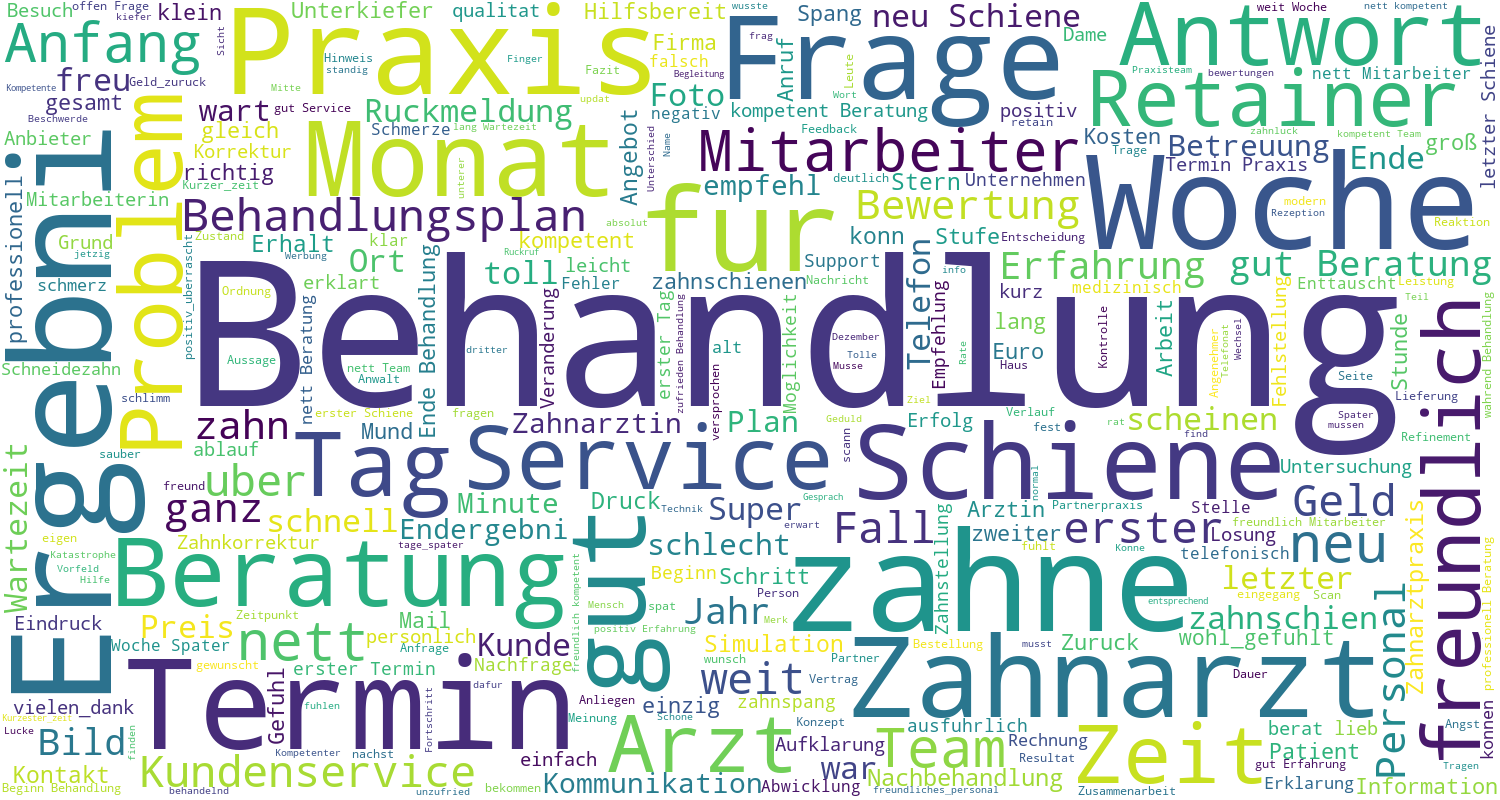

In [203]:
flat_list = [item for sublist in data_lemmatized for item in sublist]

from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(flat_list)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=300, contour_width=3, contour_color='steelblue',width=1500, height=800)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [205]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=7,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=100,
                                            passes=20,
                                            alpha='auto',
                                            per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.077*"Behandlung" + 0.066*"zahne" + 0.054*"Schiene" + 0.049*"Woche" + '
  '0.029*"neu" + 0.029*"Monat" + 0.026*"fur" + 0.021*"letzter" + '
  '0.019*"Problem" + 0.018*"Retainer"'),
 (1,
  '0.060*"Behandlungsplan" + 0.049*"Plan" + 0.047*"Jahr" + 0.042*"Preis" + '
  '0.038*"Fall" + 0.017*"zweiter" + 0.013*"einzig" + 0.013*"Besuch" + '
  '0.011*"Schone" + 0.010*"Kontakt"'),
 (2,
  '0.082*"Behandlung" + 0.064*"Termin" + 0.060*"gut" + 0.053*"Beratung" + '
  '0.051*"Frage" + 0.042*"Ergebnis" + 0.038*"erster" + 0.033*"Zahnarzt" + '
  '0.032*"Service" + 0.025*"Team"'),
 (3,
  '0.051*"weit" + 0.049*"scheinen" + 0.028*"Super" + 0.025*"Kundenservice" + '
  '0.020*"Schneidezahn" + 0.017*"groß" + 0.015*"Hilfsbereit" + '
  '0.014*"Eindruck" + 0.013*"bekommen" + 0.012*"Endergebnis"'),
 (4,
  '0.101*"Praxis" + 0.050*"nett" + 0.044*"Mitarbeiter" + 0.043*"freundlich" + '
  '0.031*"kompetent" + 0.028*"schnell" + 0.025*"Wartezeit" + 0.024*"Personal" '
  '+ 0.022*"Mund" + 0.019*"professionell"'),
 